In [183]:
import numpy as np
import scipy.stats as scs
import scipy.linalg as scl
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from fitter import Fitter, get_common_distributions, get_distributions
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from mpl_toolkits.mplot3d import axes3d

count    19177.000000
mean         0.164257
std          1.063319
min          0.020700
25%          0.079976
50%          0.108538
75%          0.144793
max         24.000000
Name: Travel_Time, dtype: float64
There is an outlier in the data. The time between dispatch and arrival for one of the entries was 24 hours, so this row was removed


(array([2.435e+03, 7.131e+03, 5.530e+03, 2.624e+03, 9.770e+02, 3.080e+02,
        8.400e+01, 3.700e+01, 1.000e+01, 3.000e+00]),
 array([0.02070011, 0.06456209, 0.10842406, 0.15228604, 0.19614801,
        0.24000999, 0.28387196, 0.32773394, 0.37159591, 0.41545789,
        0.45931986]),
 <BarContainer object of 10 artists>)

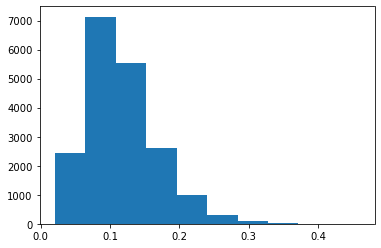

In [106]:
#Q4
amb_df = pd.read_csv('ProjectData-OHCAs.csv', index_col = [0])
amb_df['Travel_Time'] = amb_df['Amb_Arrival_Time'] - amb_df['Dispatch_Time']
print(amb_df['Travel_Time'].describe())
print("There is an outlier in the data. The time between dispatch and arrival for one of the entries was 24 hours, so this row was removed")
amb_df = amb_df[amb_df['Travel_Time']<24]
plt.hist(amb_df['Travel_Time'])
#print(amb_df['Travel_Time'].describe())

lognorm: statistic=0.006889863320311884, pvalue=0.3221463752492987
weibull_max: statistic=0.012992367908983782, pvalue=0.0030977763228222555
beta: statistic=0.03206382287859166, pvalue=1.5745849229598938e-17
weibull_min: statistic=0.032853706576045805, pvalue=2.2086027313718476e-18
gamma: statistic=0.42083404507706723, pvalue=0.0
expon: statistic=0.23929101483501813, pvalue=0.0
pareto: statistic=0.2666051998498139, pvalue=0.0


Fitting 7 distributions: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,4.014323,201.737165,-162070.376734,inf,0.006890,3.221464e-01
beta,18.758872,473.761466,-132552.043982,inf,0.032064,1.574585e-17
weibull_min,22.541863,437.350926,-129045.928903,inf,0.032854,2.208603e-18
norm,88.211507,808.582533,-102943.239617,inf,0.070206,1.798487e-82
expon,650.100340,-8.403853,-64715.205852,inf,0.239291,0.000000e+00


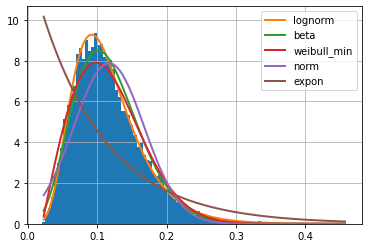

In [319]:
#Q4 fitting distribution
#Beta, Gamma, Lognormal, Exponential, Pareto, and Weibull

#list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
list_of_dists = ['beta', 'gamma', 'lognorm','expon','pareto','weibull_min','weibull_max']
results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(amb_df['Travel_Time'])
    a = stats.kstest(amb_df['Travel_Time'], i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))
    
f = Fitter(amb_df['Travel_Time'],distributions=['beta', 'gamma', 'lognorm','expon','pareto','weibull_min','norm'])
f.fit()
f.summary()

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,4.014323,201.737165,-162070.376734,inf,0.00689,0.322146


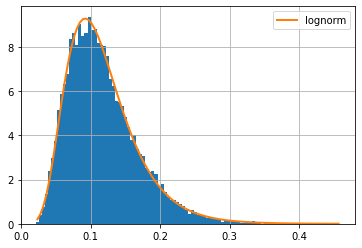

In [320]:
#Q4 with overlay on plot
f = Fitter(amb_df['Travel_Time'],distributions=['lognorm'])
f.fit()
f.summary()

The lognorm distribution was chosen since it was the best fit for the data and because travel time must be positive. The beta distribution was also considered; however, the beta distribution only takes values between 0 and 1, so it was not selected since the travel time could be more than an hour.

[Text(0.5, 1.0, 'Distribution of OHCA locations'),
 Text(0.5, 61.50502425000002, 'Longitude'),
 Text(57.875, 0.5, 'Latitude')]

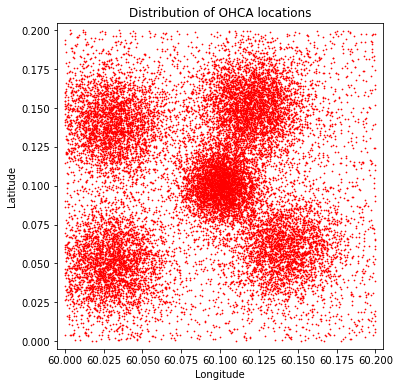

In [311]:
#Q5 scatter plot of the locations of all OHCAs
geometry = [Point(xy) for xy in zip(amb_df['Lon'],amb_df['Lat'])]
gdf = GeoDataFrame(amb_df, geometry = geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plotted = gdf.plot(ax=world.plot(figsize=(10,6)),marker='o', color = 'red', markersize=0.5)
plotted.set_ylim(amb_df['Lat'].min()-0.005, amb_df['Lat'].max()+0.005)
plotted.set_xlim(amb_df['Lon'].min()-0.005, amb_df['Lon'].max()+0.005)
plotted.set(title='Distribution of OHCA locations', xlabel='Longitude', ylabel='Latitude')

Side length of square: 0.008


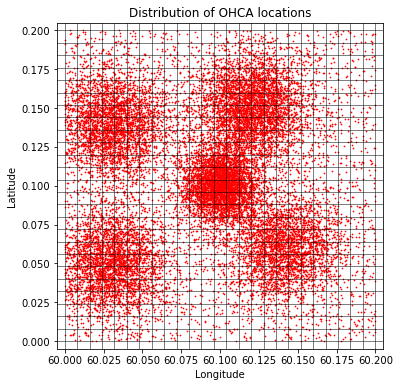

In [318]:
#Q6
#let squared have side length of lat_width

lat_width = (amb_df['Lat'].max()-amb_df['Lat'].min())/25
lat_ticks = []
x=amb_df['Lat'].min()
while x<amb_df['Lat'].max():
    lat_ticks.append(x)
    x+=lat_width
    
lon_width = (amb_df['Lon'].max()-amb_df['Lon'].min())/25
lon_ticks = []
i=amb_df['Lon'].min()
while i<amb_df['Lon'].max()+0.001:
    lon_ticks.append(i)
    i+=lat_width
print("Side length of square:", round(lat_width,3))
plotted = gdf.plot(ax=world.plot(figsize=(10,6)),marker='o', color = 'red', markersize=0.5)
plotted.set_ylim(amb_df['Lat'].min()-0.005, amb_df['Lat'].max()+0.005)
plotted.set_xlim(amb_df['Lon'].min()-0.005, amb_df['Lon'].max()+0.005)
plotted.set(title='Distribution of OHCA locations', xlabel='Longitude', ylabel='Latitude')

for l in lon_ticks:
    plt.axvline(x=l,color='black', linewidth = 0.5)
for l in lat_ticks:
    plt.axhline(y=l,color='black', linewidth = 0.5)
grid_dict = {}
num=0

for y in range(0,len(lat_ticks)-1,1):
    for x in range(0, len(lon_ticks)-1,1):
        grid_dict[num] = [[lon_ticks[x],lon_ticks[x+1]],[lat_ticks[y],lat_ticks[y+1]]]
        num+=1
#for i in grid_dict.keys():
#    plt.plot(np.mean(grid_dict[i][0]),np.mean(grid_dict[i][1]),marker='o',markersize=2,color='black')
#plt.plot(np.mean(grid_dict[12][0]),np.mean(grid_dict[12][1]),marker='o',markersize=2,color='black')

In [301]:
prop_points = []
P = np.zeros((25,25))

count = 0
lon_list= amb_df['Lon'].tolist()
lat_list=amb_df['Lat'].tolist()
for key in grid_dict.keys():
    count = 0
    for ind in range(0,len(lon_list)):
        if (grid_dict[key][0][0]<=lon_list[ind]) and (lon_list[ind] < grid_dict[key][0][1]):
            if (grid_dict[key][1][0]<=lat_list[ind] < grid_dict[key][1][1]):
                count+=1
    prop_points.append(count/len(amb_df['Lon'].tolist()))
#print(prop_points)
#print(grid_dict)

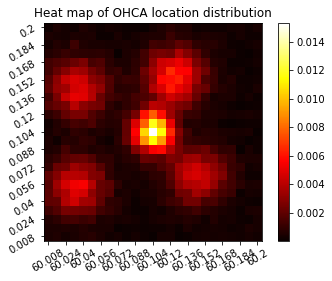

In [308]:
prop_array = np.array(prop_points).reshape(-1,25)
P = prop_array[::-1]

vals = np.arange(0,26,2)

x_t =[]
y_t=[]
for i in range(0,len(lon_ticks),2):
    x_t.append(round(lon_ticks[i+1],3))
    y_t.append(round(lat_ticks[i+1],3))
y_t = y_t[::-1]

plt.xticks(ticks = vals, labels=x_t, rotation = 30)
plt.yticks(ticks = vals, labels=y_t, rotation = 30)
plt.title('Heat map of OHCA location distribution')

plt.imshow(P, cmap= 'hot')
plt.colorbar()
plt.show()
